# Pneumonia X-ray Classification — CNN & ViT

### NAMES + IDS :
**Daniel Katz - 315114991**
**Raz Katz - 322548660**

**Objective.** Build and compare a CNN (ResNet18) and a Vision Transformer (ViT) for binary chest X-ray classification (normal vs. pneumonia).

**Key ideas.**
- Handle class imbalance via `pos_weight` in `BCEWithLogitsLoss`.
- Choose the operating threshold on the **validation set** (optimize Youden’s J).
- Track both **ROC-AUC** and **PR-AUC** (PR-AUC is more informative under imbalance).
- Ablations: backbone freezing (optional), augmentation strength, learning rate.


In [1]:
from xray_models import (
    PneumoCNN, eval_one_epoch, fit,
    pick_threshold_youden, evaluate_with_threshold, XRayViT
)

from xray_helpers import (
    seed_all, compute_pos_weight,
    balance_val_train_split, plot_curves, get_dataloaders, download_xray_dataset
)

import os
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
seed_all(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 15
PATIENCE = int(EPOCHS * 2 / 3)
LR = 1e-4

## Dataset & Splits

- **Source:** Kaggle — `paultimothymooney/chest-xray-pneumonia`.
- **Classes:** `NORMAL` (0), `PNEUMONIA` (1).
- **Re-split strategy:** Combine the original **train + val** folders and create a **stratified split**: **85% train / 15% val** (patient-level simulated via file-level stratification).
- **Counts (after split):**
  - **Train:** NORMAL = **1,147**, PNEUMONIA = **3,300**
  - **Val:** NORMAL = **202**, PNEUMONIA = **583**
  - **Test:** unchanged (original Kaggle test folder)
- **Imbalance (train):** positives ≈ **74.2%** (3,300 / 4,447).
- **Resolution:** native images → model input **224×224**.
- **Ethics & notes:** Avoid unrealistic transforms (e.g., vertical flips)

In [4]:
base_dir, train_dir, val_dir, test_dir = download_xray_dataset()

100%|██████████| 2.29G/2.29G [00:13<00:00, 185MB/s]

Extracting files...


Train dir: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train
Train dir contents: ['PNEUMONIA', 'NORMAL']
Val dir: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val
Val dir contents: ['PNEUMONIA', 'NORMAL']
Test dir: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test
Test dir contents: ['PNEUMONIA', 'NORMAL']


Before split:
train/NORMAL: 1341
train/PNEUMONIA: 3875
val/NORMAL: 8
val/PNEUMONIA: 8


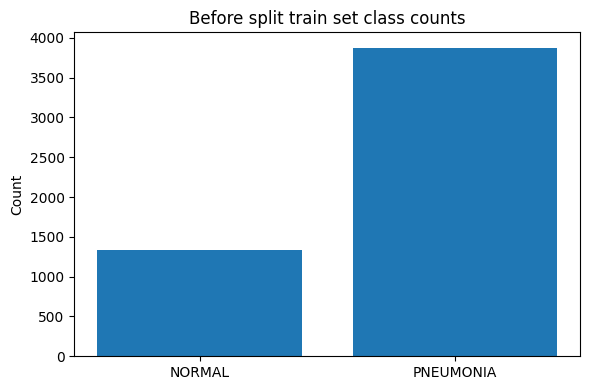

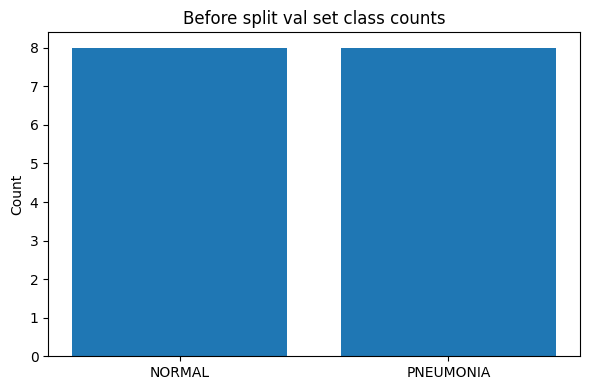

After split:
train/NORMAL: 1147
train/PNEUMONIA: 3300
val/NORMAL: 202
val/PNEUMONIA: 583


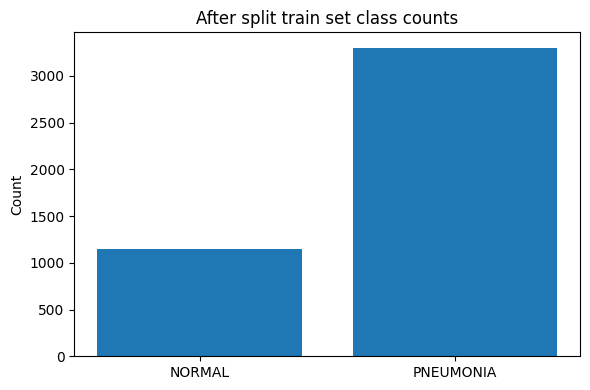

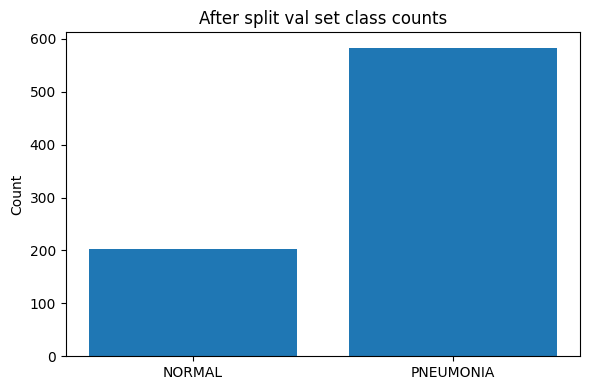

New dir: /tmp/chest_xray_split


In [5]:
new_base = balance_val_train_split(base_dir)
train_dir = os.path.join(new_base, 'train')
val_dir   = os.path.join(new_base, 'val')

## Preprocessing & Augmentation

- **Normalization:** ImageNet mean/std
  `mean=(0.485, 0.456, 0.406)` • `std=(0.229, 0.224, 0.225)`
- **Train aug:** Grayscale→3ch → Resize(256) → RandomResizedCrop(224, scale=(0.9,1.0)) → HorizontalFlip(0.5) → Rotation(±20°) → ToTensor → Normalize.
- **Val/Test:** Grayscale→3ch → Resize(256) → CenterCrop(224) → ToTensor → Normalize.
- **Rationale:** Mild geometric jitter preserves diagnostic structures while improving robustness.


In [6]:
data_sets, loaders = get_dataloaders(train_dir, val_dir, test_dir, BATCH_SIZE, NUM_WORKERS, IMG_SIZE)
print(f"Classes => {data_sets['train_ds'].classes}, , Class indices => {data_sets['train_ds'].class_to_idx}")

Classes => ['NORMAL', 'PNEUMONIA'], , Class indices => {'NORMAL': 0, 'PNEUMONIA': 1}


### ResNet18 (CNN) Backbone

In [7]:
CNN_model = PneumoCNN()
CNN_model = CNN_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


## Optimization & Training Plan

- **Device:** auto (`cuda` if available; notebook print shows `cpu` when captured)
- **Batch size:** **32**
- **Epochs:** **15**
- **Early stopping:** patience = **10** (≈ ⅔ of epochs)
- **Optimizer:** `AdamW` with **LR = 1e-4**
- **Scheduler:** `ReduceLROnPlateau(mode="max", factor=0.5, patience=2)` on **val ROC-AUC**
- **Criterion:** `BCEWithLogitsLoss(pos_weight=...)`

In [8]:
pos_weight = compute_pos_weight(data_sets['train_ds'])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = AdamW(CNN_model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

Train counts -> NEG(NORMAL)=1147, POS(PNEUMONIA)=3300, pos_weight=0.348


## Fit CNN model & plot learning curves

[Train] Epoch 1/15:   0%|          | 0/139 [00:00<?, ?it/s]

Input batch shape: torch.Size([32, 3, 224, 224])


[Eval] Epoch 1/15: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Train Loss: 0.0846, Accuracy: 0.9294, AUC: 0.9840, PR 0.9940
Val Loss: 0.0422, Accuracy: 0.9745, AUC: 0.9981, PR 0.9994


[Eval] Epoch 2/15: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


Train Loss: 0.0514, Accuracy: 0.9606, AUC: 0.9936, PR 0.9976
Val Loss: 0.0235, Accuracy: 0.9822, AUC: 0.9986, PR 0.9995


[Eval] Epoch 3/15: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Train Loss: 0.0405, Accuracy: 0.9723, AUC: 0.9959, PR 0.9986
Val Loss: 0.0208, Accuracy: 0.9898, AUC: 0.9990, PR 0.9997


[Eval] Epoch 4/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0312, Accuracy: 0.9773, AUC: 0.9975, PR 0.9992
Val Loss: 0.0588, Accuracy: 0.9732, AUC: 0.9989, PR 0.9996


[Eval] Epoch 5/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0365, Accuracy: 0.9748, AUC: 0.9967, PR 0.9989
Val Loss: 0.0257, Accuracy: 0.9873, AUC: 0.9988, PR 0.9996


[Eval] Epoch 6/15: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


Train Loss: 0.0244, Accuracy: 0.9820, AUC: 0.9983, PR 0.9994
Val Loss: 0.0473, Accuracy: 0.9796, AUC: 0.9987, PR 0.9996


[Eval] Epoch 7/15: 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]


Train Loss: 0.0196, Accuracy: 0.9856, AUC: 0.9991, PR 0.9997
Val Loss: 0.0304, Accuracy: 0.9873, AUC: 0.9990, PR 0.9997


[Eval] Epoch 8/15: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Train Loss: 0.0178, Accuracy: 0.9858, AUC: 0.9993, PR 0.9997
Val Loss: 0.0605, Accuracy: 0.9707, AUC: 0.9987, PR 0.9996


[Eval] Epoch 9/15: 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]


Train Loss: 0.0170, Accuracy: 0.9885, AUC: 0.9992, PR 0.9997
Val Loss: 0.0397, Accuracy: 0.9834, AUC: 0.9987, PR 0.9996


[Eval] Epoch 10/15: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Train Loss: 0.0112, Accuracy: 0.9917, AUC: 0.9997, PR 0.9999
Val Loss: 0.1193, Accuracy: 0.9503, AUC: 0.9987, PR 0.9996


[Eval] Epoch 11/15: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


Train Loss: 0.0113, Accuracy: 0.9930, AUC: 0.9997, PR 0.9999
Val Loss: 0.0775, Accuracy: 0.9656, AUC: 0.9990, PR 0.9997


[Eval] Epoch 12/15: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Train Loss: 0.0092, Accuracy: 0.9928, AUC: 0.9998, PR 0.9999
Val Loss: 0.0479, Accuracy: 0.9771, AUC: 0.9990, PR 0.9997


[Eval] Epoch 13/15: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Train Loss: 0.0125, Accuracy: 0.9924, AUC: 0.9995, PR 0.9998
Val Loss: 0.0654, Accuracy: 0.9720, AUC: 0.9992, PR 0.9997


[Eval] Epoch 14/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0078, Accuracy: 0.9953, AUC: 0.9999, PR 0.9999
Val Loss: 0.0734, Accuracy: 0.9707, AUC: 0.9992, PR 0.9997


[Eval] Epoch 15/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0086, Accuracy: 0.9951, AUC: 0.9998, PR 0.9999
Val Loss: 0.0585, Accuracy: 0.9732, AUC: 0.9990, PR 0.9997
Training finished in 16.2 min. Best val AUC: 0.9992


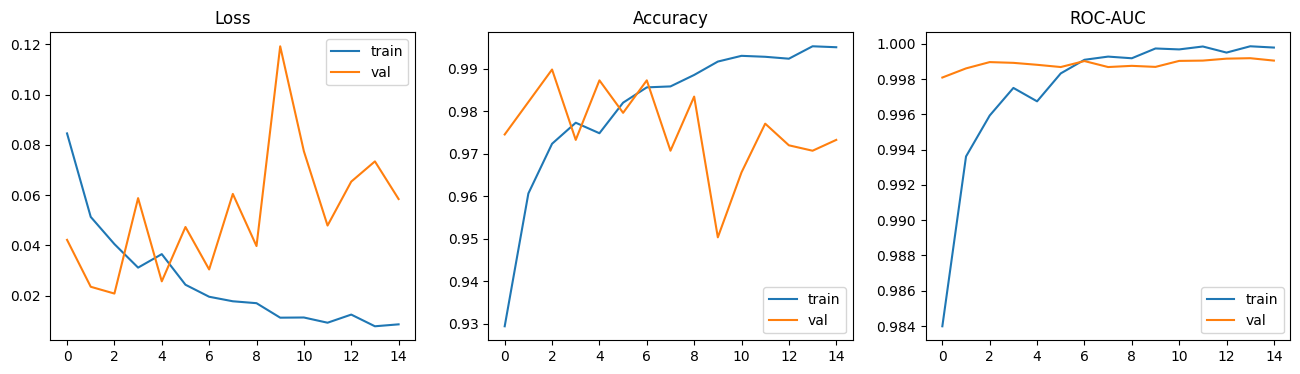

In [9]:
history, best_val_auc = fit(CNN_model, loaders['train_loader'], loaders['val_loader'],criterion, optimizer, device, scheduler, epochs=EPOCHS, patience=PATIENCE)
plot_curves(history)

## Metrics & Threshold Selection

- Tracked per epoch: **Loss**, **Accuracy**, **ROC-AUC**, **PR-AUC**.
- Decision threshold is **not fixed at 0.5**. On validation predictions, choose:
  - **Youden’s J** (implemented as `pick_threshold_youden`)
  - A **target-recall** operating point for higher sensitivity.
- Report **test** metrics using the **val-chosen** threshold to avoid leakage.


In [10]:
_, _, _, va_auc, va_probs, va_targets = eval_one_epoch(CNN_model, loaders['val_loader'], 1, criterion, device, 1)
best_thr = pick_threshold_youden(va_targets, va_probs)
print("Chosen threshold:", best_thr)

[Eval] Epoch 1/1: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]

Chosen threshold: 0.9931650757789612


## Evaluate CNN model on test set using the chosen threshold

[Eval] Epoch 1/15: 100%|██████████| 20/20 [00:08<00:00,  2.34it/s]

probs[:10] = [0.05068279 0.00513872 0.43711686 0.987673   0.95921975 0.4381691
 0.15504815 0.94993174 0.9910952  0.79153156]
targets[:10] = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
TEST — loss: 1.0828 | acc@thr: 0.9038 | auc: 0.9602
Specificity: 0.7650 | Sensitivity: 0.9872 | Balanced Acc: 0.8761
PR-AUC from average_precision_score: 0.9707  | PR-AUC from sklearn.metrics: 0.9707
Confusion Matrix :
 [[179  55]
 [  5 385]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.9728    0.7650    0.8565       234
   PNEUMONIA     0.8750    0.9872    0.9277       390

    accuracy                         0.9038       624
   macro avg     0.9239    0.8761    0.8921       624
weighted avg     0.9117    0.9038    0.9010       624



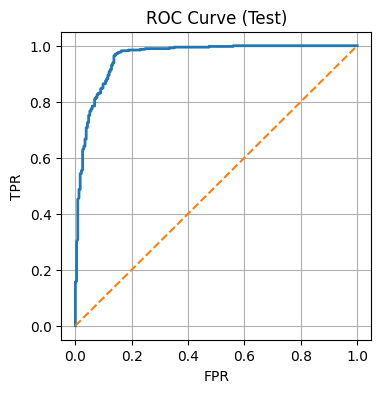

In [11]:
evaluate_with_threshold(CNN_model, loaders['test_loader'], criterion, best_thr, device, EPOCHS)

## Vision Transformer (ViT) Backbone

In [12]:
model_vit = XRayViT(
    img_size=224, patch_size=16, in_chans=3,
    embed_dim=384, depth=8, num_heads=6, mlp_ratio=4.0,
    drop_rate=0.1, attn_drop_rate=0.0, drop_path_rate=0.1
).to(device)

model_vit = XRayViT().to(device)

## Criterion, Optimizer, Scheduler & Training for ViT

In [13]:
data_sets, loaders = get_dataloaders(train_dir, val_dir, test_dir, BATCH_SIZE, NUM_WORKERS, IMG_SIZE)
pos_weight = compute_pos_weight(data_sets['train_ds'])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = AdamW(model_vit.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

Train counts -> NEG(NORMAL)=1147, POS(PNEUMONIA)=3300, pos_weight=0.348


## Fit ViT model & plot learning curves

[Train] Epoch 1/15:   0%|          | 0/139 [00:00<?, ?it/s]

Input batch shape: torch.Size([32, 3, 224, 224])


[Eval] Epoch 1/15: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.3529, Accuracy: 0.5098, AUC: 0.5820, PR 0.8028
Val Loss: 0.3227, Accuracy: 0.6280, AUC: 0.6950, PR 0.8801


[Eval] Epoch 2/15: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.2813, Accuracy: 0.7063, AUC: 0.7940, PR 0.9173
Val Loss: 0.2663, Accuracy: 0.6726, AUC: 0.9052, PR 0.9665


[Eval] Epoch 3/15: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Train Loss: 0.2136, Accuracy: 0.7868, AUC: 0.8869, PR 0.9589
Val Loss: 0.1641, Accuracy: 0.8331, AUC: 0.9431, PR 0.9788


[Eval] Epoch 4/15: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.1730, Accuracy: 0.8484, AUC: 0.9278, PR 0.9737
Val Loss: 0.1449, Accuracy: 0.8586, AUC: 0.9497, PR 0.9830


[Eval] Epoch 5/15: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.1741, Accuracy: 0.8442, AUC: 0.9271, PR 0.9742
Val Loss: 0.1660, Accuracy: 0.8943, AUC: 0.9524, PR 0.9839


[Eval] Epoch 6/15: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Train Loss: 0.1501, Accuracy: 0.8738, AUC: 0.9456, PR 0.9803
Val Loss: 0.1526, Accuracy: 0.8968, AUC: 0.9592, PR 0.9857


[Eval] Epoch 7/15: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.1503, Accuracy: 0.8725, AUC: 0.9447, PR 0.9806
Val Loss: 0.1823, Accuracy: 0.9083, AUC: 0.9619, PR 0.9856


[Eval] Epoch 8/15: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Train Loss: 0.1497, Accuracy: 0.8698, AUC: 0.9461, PR 0.9809
Val Loss: 0.1442, Accuracy: 0.8395, AUC: 0.9584, PR 0.9856


[Eval] Epoch 9/15: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.1459, Accuracy: 0.8797, AUC: 0.9499, PR 0.9814
Val Loss: 0.1423, Accuracy: 0.9185, AUC: 0.9654, PR 0.9876


[Eval] Epoch 10/15: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.1341, Accuracy: 0.8833, AUC: 0.9586, PR 0.9851
Val Loss: 0.1218, Accuracy: 0.8879, AUC: 0.9673, PR 0.9884


[Eval] Epoch 11/15: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.1318, Accuracy: 0.8864, AUC: 0.9592, PR 0.9857
Val Loss: 0.1383, Accuracy: 0.8510, AUC: 0.9607, PR 0.9867


[Eval] Epoch 12/15: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.1371, Accuracy: 0.8788, AUC: 0.9554, PR 0.9843
Val Loss: 0.1218, Accuracy: 0.9223, AUC: 0.9698, PR 0.9898


[Eval] Epoch 13/15: 100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.1364, Accuracy: 0.8851, AUC: 0.9566, PR 0.9844
Val Loss: 0.1331, Accuracy: 0.9274, AUC: 0.9739, PR 0.9909


[Eval] Epoch 14/15: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.1181, Accuracy: 0.8993, AUC: 0.9676, PR 0.9886
Val Loss: 0.1140, Accuracy: 0.8803, AUC: 0.9736, PR 0.9912


[Eval] Epoch 15/15: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.1374, Accuracy: 0.8786, AUC: 0.9545, PR 0.9841
Val Loss: 0.1066, Accuracy: 0.8930, AUC: 0.9767, PR 0.9920
Training finished in 16.5 min. Best val AUC: 0.9767


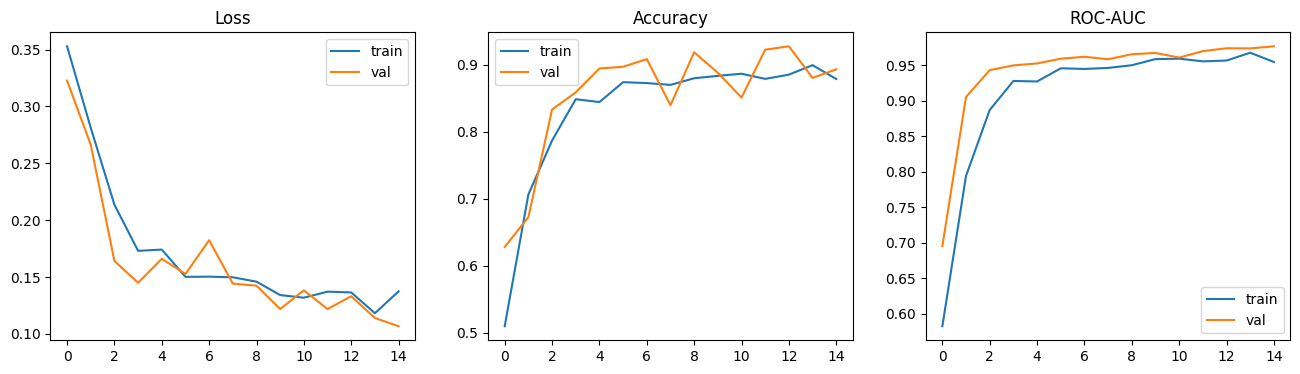

In [14]:
history_vit, best_val_auc_vit = fit(model_vit, loaders['train_loader'], loaders['val_loader'], criterion, optimizer, device, scheduler, epochs=EPOCHS, patience=PATIENCE)
plot_curves(history_vit)

## Evaluate ViT model on validation set, choose threshold & evaluate on test set

In [15]:
_, _, _, va_auc, va_probs, va_targets = eval_one_epoch(model_vit, loaders['val_loader'], 1, criterion, device, 1)
best_thr = pick_threshold_youden(va_targets, va_probs)
print("Chosen threshold:", best_thr)

[Eval] Epoch 1/1: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

Chosen threshold: 0.28787174820899963


## Final test evaluation for ViT

[Eval] Epoch 1/15: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]

probs[:10] = [0.09668678 0.05500974 0.03903895 0.04918374 0.01473029 0.05394366
 0.07311315 0.05754593 0.11765069 0.068506  ]
targets[:10] = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
TEST — loss: 0.3211 | acc@thr: 0.8269 | auc: 0.9223
Specificity: 0.6239 | Sensitivity: 0.9487 | Balanced Acc: 0.7863
PR-AUC from average_precision_score: 0.9507  | PR-AUC from sklearn.metrics: 0.9507
Confusion Matrix :
 [[146  88]
 [ 20 370]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.8795    0.6239    0.7300       234
   PNEUMONIA     0.8079    0.9487    0.8726       390

    accuracy                         0.8269       624
   macro avg     0.8437    0.7863    0.8013       624
weighted avg     0.8347    0.8269    0.8192       624



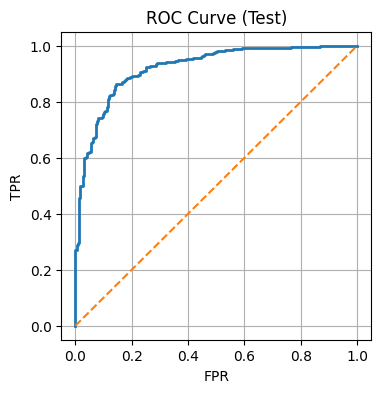

In [16]:
evaluate_with_threshold(model_vit, loaders['test_loader'], criterion, best_thr, device, EPOCHS)